In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

In [14]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [15]:
TIC = 'TIC 420779000' #HAT-P-26b / TIC 420779000

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 420779000" SECTOR=50 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [16]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2665.276621666103,1.0008752e+00,1.6877042e-03,5.0983941e-03,1035228,1712.50806,1864.32177,6.1302373e+03,1.0319491e+01,1.5157616e+03,3.7660410e+00,7.1721631e+03,1.2093904e+01,0,———,———,———,———,1712.50806,1.3248915e-03,1864.32177,1.3110075e-03,-3.7879929e-02,1.0244901e-01
2665.2780106009227,9.9939626e-01,1.6885798e-03,5.0984407e-03,1035229,1712.51308,1864.32094,6.1227061e+03,1.0324845e+01,1.5224823e+03,3.7810454e+00,7.1615649e+03,1.2100179e+01,0,———,———,———,———,1712.51308,1.3261628e-03,1864.32094,1.3112831e-03,-3.2004643e-02,1.0131135e-01
2665.2793995357433,9.9927253e-01,1.6881203e-03,5.0984873e-03,1035230,1712.51125,1864.31516,6.1217334e+03,1.0322036e+01,1.5206570e+03,3.7757792e+00,7.1606782e+03,1.2096887e+01,0,———,———,———,———,1712.51125,1.3261768e-03,1864.31516,1.3103712e-03,-3.7128687e-02,9.5918149e-02
2665.2807884705635,1.0043720e+00,1.6912979e-03,5.0985338e-03,1035231,1712.50948,1864.32062,6.1531748e+03,1.0341465e+01,1.5216674e+03,3.7705452e+00,7.1972202e+03,1.2119657e+01,0,———,———,———,———,1712.50948,1.3216167e-03,1864.32062,1.3083346e-03,-3.4576565e-02,1.0225669e-01
2665.2821774058493,1.0007608e+00,1.6884294e-03,5.0985808e-03,1035232,1712.50742,1864.31755,6.1306606e+03,1.0323926e+01,1.5226661e+03,3.7688382e+00,7.1713428e+03,1.2099101e+01,0,———,———,———,———,1712.50742,1.3256199e-03,1864.31755,1.3087012e-03,-3.8559388e-02,1.0009597e-01
2665.2835663406704,9.9956930e-01,1.6884031e-03,5.0986274e-03,1035233,1712.51242,1864.31983,6.1226650e+03,1.0323764e+01,1.5179741e+03,3.7734630e+00,7.1628047e+03,1.2098912e+01,0,———,———,———,———,1712.51242,1.3269043e-03,1864.31983,1.3105640e-03,-3.4752984e-02,1.0057126e-01
2665.2849552754915,9.9820203e-01,1.6865281e-03,5.0986740e-03,1035234,1712.50889,1864.31878,6.1138428e+03,1.0312301e+01,1.5209933e+03,3.7675910e+00,7.1530068e+03,1.2085477e+01,0,———,———,———,———,1712.50889,1.3263194e-03,1864.31878,1.3127550e-03,-3.9159257e-02,1.0016379e-01
2665.2863442103117,9.9677658e-01,1.6860449e-03,5.0987205e-03,1035235,1712.51207,1864.32187,6.1045146e+03,1.0309346e+01,1.5252603e+03,3.7711377e+00,7.1427925e+03,1.2082014e+01,0,———,———,———,———,1712.51207,1.3281615e-03,1864.32187,1.3129751e-03,-3.5147920e-02,1.0174066e-01


In [17]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

In [18]:
prior_Rs = 0.8564404 #R_sun, Gaia DR2

guess_params = batman.TransitParams()
guess_params.w = 46.0 #(Deg) longitude of periastron; Knutson et al. 2014
# guess_params.ecc = 0.12 #Stassun et al. 2017
guess_params.limb_dark = "quadratic"
guess_params.u = [0.43885935628841155, 0.17612013577695576] #limb darkening coefficients


In [19]:
prior_t0 = 	2670.424 #(Days) Myself, from fixed eccentricty run, batman only model
prior_rprs = 0.0724 #Myself, from HAT-P-26b fixed eccentricty run, batman only model
prior_per = 4.23440 #Myself, from HAT-P-26b fixed eccentricty run, batman only model
prior_inc =  87.4 #Myself, from HAT-P-26b fixed eccentricty run, batman only model
prior_a = 11.71 #a/R* Myself, from HAT-P-26b fixed eccentricty run, batman only model
prior_eccen = 0.12 #Stassun et al. 2017

guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a, prior_eccen]

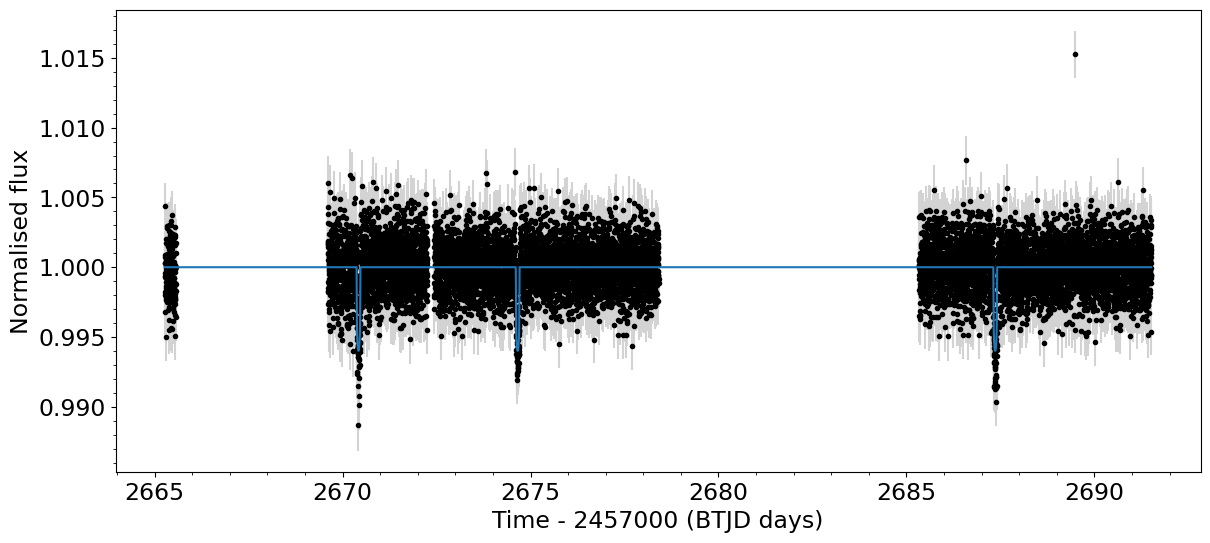

In [20]:
check_params = batman.TransitParams()
check_params.ecc = prior_eccen
check_params.w = guess_params.w
check_params.limb_dark = guess_params.limb_dark
check_params.u = guess_params.u
check_params.t0 = prior_t0
check_params.rp = prior_rprs #Rp/R*
check_params.per = prior_per
check_params.inc = prior_inc
check_params.a = prior_a #a/R*
check_m = batman.TransitModel(check_params, t)
check_params_flux = check_m.light_curve(check_params)


fig, ax = plt.subplots(1, figsize=(14,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')
plt.plot(t, check_params_flux, zorder=10)

plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [21]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, eccentricity = prior_params

    guess_params.t0 = t_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis #a/R*
    guess_params.ecc = eccentricity
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)

    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, eccentricity = prior_params

    P = 0.0
    if (t_0 < 2670.0) or (t_0 > 2671.0): #Days
        return -np.inf

    if (R_planet_stellar < 0.0) or (R_planet_stellar > 1.167):
        return -np.inf

    if (orbital_period < 4.2) or (orbital_period > 4.3): #Days
        return -np.inf

    if (orbital_inclination < 85) or (orbital_inclination > 90): #Degrees
        return -np.inf
    
    if (semi_major_axis < 6) or (semi_major_axis > 20): #a/R*
        return -np.inf

    if (eccentricity < 0.0) or (eccentricity > 0.5): #Eccentricity
        return -np.inf
    

    #Informed log Gaussian prior
    # e = 0.12+/-0.06 (Stassun et al. 2017)
    e_mu = 0.12
    e_sigma = 0.06
    P += np.log(np.exp(-0.5*(( (eccentricity - e_mu) / e_sigma )**2)) / (e_sigma * np.sqrt(2 * np.pi)))
    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [22]:
scatter = 1E-8 #Walker scattering of the parameters

pos = guess + scatter * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "HAT_P_26b_free_ecc_batman.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    print("Start:       {}".format(time.ctime(int(start_time))))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs), a=2)
    sampler.run_mcmc(pos, 50000, progress=True)
    
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

Start:       Wed Feb 15 10:38:29 2023


  0%|          | 70/50000 [00:04<51:13, 16.25it/s]  Traceback (most recent call last):
  File "c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_4280\1885900863.py", line 75, in log_prob
    return log_likelihood(prior_params, true_flux, yerrs) + lp
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_4280\1885900863.py", line 24, in log_likelihood
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
KeyboardInterrupt
  0%|          | 71/50000 [00:04<55:39, 14.95it/s]


emcee: Exception while calling your likelihood function:
  params: [2.67042449e+03 7.29552272e-02 4.23473429e+00 8.73993321e+01
 1.17094289e+01 1.19807443e-01]
  args: (array([1.0008752 , 0.99939626, 0.9992725 , ..., 1.0029957 , 1.0012279 ,
       0.9994375 ], dtype=float32), array([0.0016877 , 0.00168858, 0.00168812, ..., 0.00169257, 0.00169271,
       0.00169175], dtype=float32))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

In [ ]:
filename = "HAT_P_26b_free_ecc_batman_flat_samples.p"
file = open(filename, "wb")
pickle.dump(flat_samples, file)
file.close()

In [ ]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$T_{0}$ (Days)", "$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis ($a/R_{*}$)", "Eccentricity ($e$)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(x=burnin, color='red', ls="--",alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()

In [ ]:
labels = ["$T_{0}$ (Days)", "$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis ($a/R_{*}$)", "Eccentricity ($e$)"]
fig = corner.corner(
    flat_samples, labels=labels, truths=guess)

In [ ]:
transit_params = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])

    val = "{}+{}-{}".format(mcmc[1], q[0], q[1])
    entry = [labels[i], val]
    transit_params.append(entry)

    display(Math(txt))

df = pd.DataFrame(data=transit_params)

df.to_csv("HAT_P_26b_free_ecc_batman_params.csv",header=False, index=False)